In [1]:
%%sh
ls ./data/

fhv_tripdata_2021-01.parquet
fhv_tripdata_2021-02.parquet
yellow_tripdata_2023-01.parquet
yellow_tripdata_2023-02.parquet


In [2]:
!python -V

Python 3.8.19


In [3]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

## Read the data for January. How many records are there?

In [4]:
df = pd.read_parquet("./data/yellow_tripdata_2023-01.parquet")

In [5]:
records = df.shape[0]
print(f"There are {records} records")
print(f"Dataframes shape {df.shape}")

There are 3066766 records
Dataframes shape (3066766, 19)


In [6]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [7]:
df["duration"] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df["duration"] = df.duration.apply(lambda t: t.total_seconds() / 60.0 )

In [8]:
df.duration.mean(), df.duration.std()

(15.668995167330452, 42.594351241920904)

In [9]:
df.duration.describe()

count    3.066766e+06
mean     1.566900e+01
std      4.259435e+01
min     -2.920000e+01
25%      7.116667e+00
50%      1.151667e+01
75%      1.830000e+01
max      1.002918e+04
Name: duration, dtype: float64

In [10]:
df = df.loc[(df.duration >= 1) & (df.duration <= 60)]

In [11]:
df.shape[0] / records * 100, records - df.shape[0]

(98.1220282212598, 57593)

In [12]:
def prepare_data(filename, categorical_cols):
    df = pd.read_parquet(filename)
    df["duration"] =  df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df["duration"] = df.duration.apply(lambda t: t.total_seconds() / 60.0 )

    df = df.loc[(df.duration >= 1) & (df.duration <= 60)]
    
    df[categorical_cols] = df[categorical_cols].astype(str)
    return df


def vectorize(df, categorical_cols,train=False):
    dicts = df[categorical_cols].to_dict(orient='records')

    if train:
        dv = DictVectorizer()
        X = dv.fit_transform(dicts)
        with open('models/dv.bin', 'wb') as f_out:
                pickle.dump(dv, f_out)
    else:
        with open('models/dv.bin', 'rb') as f_in:
            dv = pickle.load(f_in)
        X = dv.transform(dicts)       
    return X, get_target(df)



def get_target(df):
    target = 'duration'
    return df[target].values 

def train(X_train,y_train):
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    return lr

In [13]:
categorical_cols = ['PULocationID', 'DOLocationID']
df_train = prepare_data("./data/yellow_tripdata_2023-01.parquet",categorical_cols)
X_train,y_train = vectorize(df_train,categorical_cols,True)
print(f"number of columns {X_train.shape[1]}")
lr_trained = train(X_train,y_train)
y_pred = lr_trained.predict(X_train)

print(f"train rmse: {mean_squared_error(y_train, y_pred, squared=False)}")

number of columns 515
train rmse: 7.6492619241381785


In [14]:
df_val = prepare_data("./data/yellow_tripdata_2023-02.parquet",categorical_cols)
X_val,y_val = vectorize(df_val,categorical_cols,False)
y_pred = lr_trained.predict(X_val)

print(f"val rmse: {mean_squared_error(y_val, y_pred, squared=False)}")

val rmse: 7.811818380595618


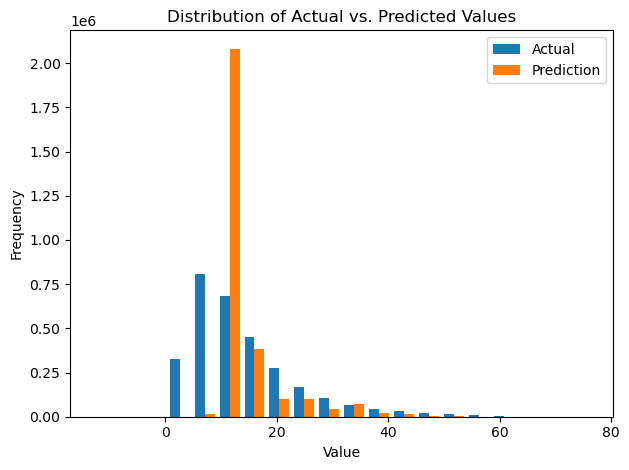

In [15]:
plt.hist([y_train, y_pred], label=["Actual", "Prediction"], histtype='bar', stacked=False, bins =20)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Distribution of Actual vs. Predicted Values")
plt.legend()
plt.tight_layout()
plt.show()